# Lab3: Levenshtein distance and spelling corrections

In [64]:
import collections
import elasticsearch
import elasticsearch_dsl
import itertools
import Levenshtein
import locale
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import spacy
import spacy.lang.pl
import spacy.tokenizer
import time

In [2]:
locale.setlocale(locale.LC_COLLATE, 'pl_PL.UTF-8')

'pl_PL.UTF-8'

In [3]:
ACT_DIRECTORY = '../files'

## 1. Use SpaCy tokenizer API to tokenize the text from the law corpus.

Po utorzeniu tokenizatora opartego o pretrenowany model języka polskiego treści plików zostały poddane tokenizacji i wczytane do słownika.

In [4]:
nlp = spacy.load('pl_core_news_sm')
# Create a Tokenizer with the default settings for Polish
# including punctuation rules and exceptions
tokenizer = nlp.Defaults.create_tokenizer(nlp)

In [5]:
all_tokens_per_file = {}

for root, _, files in os.walk(ACT_DIRECTORY):
    for file_name in files:
        path = os.path.join(root, file_name)
        with open(path, encoding='utf-8') as file:
            content = file.read()
            all_tokens_per_file[path] = [token.text.lower() for token in tokenizer(content)]

## 2. Compute frequency list for each of the processed files.

Poniżej zaprezentowane jest 5 najpopularniejszych tokenów z pierwszych 10 plików. Łatwo zauważyć, że raczej nie są one dla nas interesujące.

In [6]:
all_frequencies_per_file = {
    path: collections.Counter(tokens)
    for (path, tokens) 
    in all_tokens_per_file.items()
}

In [7]:
for file, counter in sorted(all_frequencies_per_file.items())[:10]:
    print(f'{file.split("/")[-1]}: {counter.most_common(5)}')

1993_599.txt: [('|', 1634), ('-', 858), ('\n', 561), ('.', 497), ('   ', 485)]
1993_602.txt: [('.', 155), (',', 89), ('w', 63), ('"', 44), ('\n          ', 36)]
1993_645.txt: [('.', 23), (',', 7), ('\n', 7), ('z', 6), ('r', 6)]
1993_646.txt: [('.', 688), (',', 610), ('w', 506), ('-', 324), ('"', 304)]
1994_150.txt: [('.', 20), (',', 6), ('w', 6), ('z', 5), ('i', 4)]
1994_195.txt: [('.', 2724), (',', 2197), ('\n  ', 1368), ('w', 1226), ('\n', 1117)]
1994_201.txt: [('.', 36), (',', 19), ('\n                ', 19), ('i', 9), ('z', 8)]
1994_214.txt: [('.', 17), ('\n', 5), ('w', 4), ('"', 4), ('z', 3)]
1994_215.txt: [('.', 39), (',', 23), ('w', 14), ('z', 8), ('\n       ', 8)]
1994_288.txt: [(',', 26), ('.', 23), ('w', 17), (')', 16), ('\n', 11)]


## 3. Aggregate the result to obtain one global frequency list.

Poniżej zaprezentowane jest 10 najpopularniejszych globalnie słów. Również tutaj widać, że raczej nie są one dla nas interesujące.

In [8]:
all_tokens = [token for tokens in all_tokens_per_file.values() for token in tokens]
all_global_frequency = collections.Counter(all_tokens)
all_global_frequency.most_common(10)

[('.', 441565),
 (',', 342866),
 ('w', 202063),
 ('\n', 184442),
 (')', 100755),
 ('i', 90324),
 ('art', 84246),
 ('z', 82814),
 ('1', 73637),
 ('-', 66220)]

## 4. Reject all entries that are shorter than 2 characters or contain non-letter characters (make sure to include Polish diacritics).

Pole `is_alpha` tokenów spaCy pozwala na wykrycie tokenów zawierających same litery i poprawnie obsługuje polskie znaki.

In [9]:
tokenizer('ęśąćż')[0].is_alpha

True

In [10]:
tokenizer('70milionów')[0].is_alpha

False

Rozważałam również wykorzystanie pola `is_stop` w celu eliminacji stopwordsów, jednak polecenie wskazywało konkretnie na słowa jednoliterowe -- zatem zostawiamy słowo "oraz", ale eliminujemy "w" oraz "i".

In [11]:
tokenizer('Ąśćź')[0].is_stop

False

In [12]:
tokenizer('i')[0].is_stop

True

In [13]:
tokenizer('oraz')[0].is_stop

True

In [15]:
tokens_per_file = {}

for root, _, files in os.walk(ACT_DIRECTORY):
    for file_name in files:
        path = os.path.join(root, file_name)
        with open(path, encoding='utf-8') as file:
            content = file.read()
            tokens_per_file[path] = [
                token.text.lower()
                for token 
                in tokenizer(content) 
                if token.is_alpha 
                # and not token.is_stop
                and len(token) > 1
            ]

### Najpopularniejsze tokeny per plik

Poniżej zaprezentowane jest 5 najpopularniejszych słów z pierwszych 10 plików po wyeliminowaniu krótkich słów oraz tokenów zawierających znaki inne niż litery.

In [18]:
frequencies_per_file = {
    path: collections.Counter(tokens)
    for (path, tokens) 
    in tokens_per_file.items()
}

In [19]:
for file, counter in sorted(frequencies_per_file.items())[:10]:
    print(f'{file.split("/")[-1]}: {counter.most_common(5)}')

1993_599.txt: [('ust', 118), ('art', 75), ('do', 69), ('się', 66), ('towarów', 49)]
1993_602.txt: [('ust', 29), ('nr', 28), ('poz', 28), ('art', 25), ('wynagrodzenia', 13)]
1993_645.txt: [('nr', 6), ('poz', 6), ('dnia', 3), ('oraz', 3), ('art', 3)]
1993_646.txt: [('ust', 193), ('art', 166), ('się', 126), ('pkt', 107), ('od', 102)]
1994_150.txt: [('art', 4), ('lub', 4), ('dnia', 3), ('do', 3), ('dz', 2)]
1994_195.txt: [('art', 510), ('do', 502), ('na', 459), ('się', 349), ('lub', 321)]
1994_201.txt: [('art', 7), ('oraz', 5), ('rejonów', 5), ('nr', 4), ('poz', 4)]
1994_214.txt: [('dnia', 3), ('art', 3), ('dz', 2), ('nr', 2), ('poz', 2)]
1994_215.txt: [('ust', 7), ('nr', 6), ('poz', 6), ('art', 6), ('dnia', 3)]
1994_288.txt: [('rolnych', 7), ('art', 7), ('dnia', 4), ('zadania', 4), ('związanych', 3)]


### Globalnie nalpopularniejsze tokeny

Poniżej zaprezentowane jest 10 najpopularniejszych globalnie słów po wyeliminowaniu krótkich słów oraz tokenów zawierających znaki inne niż litery.

In [21]:
all_tokens = [token for tokens in tokens_per_file.values() for token in tokens]
global_frequency = collections.Counter(all_tokens)
global_frequency.most_common(10)

[('art', 84246),
 ('do', 60977),
 ('ust', 53686),
 ('na', 50805),
 ('lub', 46100),
 ('się', 46066),
 ('poz', 45481),
 ('nr', 45157),
 ('oraz', 33654),
 ('mowa', 28891)]

## 5. Make a plot in a logarithmic scale:
* X-axis should contain the rank of a term, meaning the first rank belongs to the term with the highest number of occurrences; the terms with the same number of occurrences should be ordered by their name,
* Y-axis should contain the number of occurrences of the term with given rank.

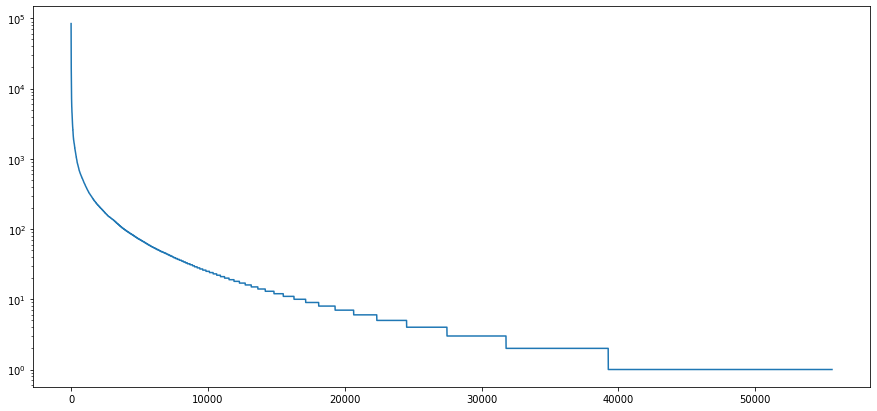

In [22]:
global_frequency_list = sorted(global_frequency.items(), key=lambda item: (-item[1], item[0]))

plt.figure(figsize=(15, 7))
plt.plot(range(1, len(global_frequency_list) + 1), [frequency for (_, frequency) in global_frequency_list])
plt.yscale('log')

## 6. Download polimorfologik.zip dictionary and use it to find all words that do not appear in that dictionary.

Z README znalezionego w zipie dowiedziałam się, jak wygląda format pliku.

```
4. polimorfologik-2.1 PoliMorf.txt to zwykły plik tekstowy w kodowaniu UTF-8 o formacie:
    forma podstawowa;forma odmieniona;znaczniki gramatyczne
```

W związku z tym wykorzystane zostanie drugie ze słów znajdujących się w ciągu oddzielonym średnikami.

In [27]:
with open('../polimorfologik/polimorfologik-2.1.txt') as file:
    polimorfologik_words = [line.split(';')[1].lower() for line in file.readlines()]

Kilka przykładowych słów zostało wyprintowane poniżej.

In [28]:
polimorfologik_words[::123456]

['aa',
 'koniorami',
 'szalczykowi',
 'autogeniczni',
 'chedywi',
 'dokumencina',
 'erotomańskościami',
 'gładkopokładowiec',
 'kapuchą',
 'krząkającym',
 'metra',
 'nakrapiaj',
 'niebibliotecznościach',
 'nieetykietującej',
 'niekorumpowane',
 'nienobliwie',
 'niepodciekającej',
 'nieprzełażonym',
 'nieskowronkowatość',
 'nieuralo-ałtajskościach',
 'niezaczepnego',
 'nowobytomianie',
 'odratowywałaś',
 'otrzymywane',
 'podejrzewającej',
 'poprzekomarzając',
 'prawującego',
 'przewaga',
 'rabuśniczych',
 'rozserdecznialiby',
 'skomlisz',
 'superdostojny',
 'trzcinami',
 'ustabilizowanie',
 'wpustnik',
 'wypełzałeś',
 'zaczopowanej',
 'zatrutej',
 'zniemożeniu']

## 7. Find 30 words with the highest ranks that do not belong to the dictionary.

In [24]:
def find_words(condition):
    for word, frequency in global_frequency_list:
        if condition((word, frequency)):
            yield (word, frequency)

In [75]:
for result in itertools.islice(find_words(lambda pair: pair[0] not in polimorfologik_words), 30):
    print(result)

('margin', 1097)
('późn', 1080)
('text', 531)
('mso', 448)
('face', 327)
('panose', 326)
('gmo', 298)
('sa', 266)
('iv', 263)
('align', 234)
('sww', 216)
('justify', 200)
('skw', 196)
('div', 182)
('line', 169)
('ex', 167)
('ike', 162)
('autospace', 155)
('none', 154)
('vi', 146)
('remediacji', 120)
('vii', 106)
('ure', 103)
('family', 102)
('uke', 97)
('kn', 95)
('cn', 83)
('pkwiu', 81)
('span', 77)
('udt', 77)


## 8. Find 30 words with 5 occurrences that do not belong to the dictionary.

In [29]:
for result in itertools.islice(find_words(lambda pair: pair[1] == 5 and pair[0] not in polimorfologik_words), 30):
    print(result)

('adopcyjnoopiekuńczych', 5)
('agave', 5)
('ami', 5)
('anonimizacji', 5)
('betezda', 5)
('contagious', 5)
('cznika', 5)
('difenylopropylo', 5)
('ekofizjograficznych', 5)
('eudravigilance', 5)
('gj', 5)
('heptanol', 5)
('inci', 5)
('instrumen', 5)
('izobutyl', 5)
('jed', 5)
('jwh', 5)
('kj', 5)
('kpwig', 5)
('metylofenetyloamina', 5)
('najmnie', 5)
('naliczeń', 5)
('naukowobadawczych', 5)
('nawodnień', 5)
('niskomorfinowego', 5)
('nym', 5)
('odgazowywacze', 5)
('odwzorowań', 5)
('organicz', 5)
('ośc', 5)


## 9. Use Levenshtein distance and the frequency list, to determine the most probable correction of the words from the second list. (You don't have to apply the distance directly. Any method that is more efficient than scanning the dictionary will be appreciated.)

In [30]:
words_to_spellcheck = list(
    itertools.islice(find_words(lambda pair: pair[1] == 5 and pair[0] not in polimorfologik_words), 30)
)

Utworzona została macierz odległości Levenshteina.

In [65]:
possible_suggestions = np.array(possible_suggestions)

start = time.time()

distance_matrix = np.zeros((len(words_to_spellcheck), len(possible_suggestions)), dtype=np.int)

for i, (word1, _) in enumerate(words_to_spellcheck):
    for j, word2 in enumerate(possible_suggestions):
        distance_matrix[i, j] = Levenshtein.distance(word1, word2)
        
print(f'{(time.time() - start)} s')

146.6512930393219


In [45]:
for index, word in enumerate(words_to_spellcheck):
    distance_vector = distance_matrix[index, :]
    minimum_distance = distance_vector.min()
    min_indices = np.where(distance_vector == minimum_distance)
    print(f'Słowo: {word[0]}, dystans: {minimum_distance}, sugestie poprawki: {", ".join(possible_suggestions[min_indices])}')

Słowo: adopcyjnoopiekuńczych, dystans: 8, sugestie poprawki: nadopiekuńczych
Słowo: agave, dystans: 1, sugestie poprawki: agape
Słowo: ami, dystans: 1, sugestie poprawki: ai, am, api, agi, ali, ali, amig, ani, asi, ażi, rami, agi, ali, am, amb, amf, amia, amic, amid, amid, amie, amii, amin, amio, amią, amię, ani, kami, mami, mi, mi, nami, rami, sami, wami, ćmi, ćmi
Słowo: anonimizacji, dystans: 2, sugestie poprawki: animizacji
Słowo: betezda, dystans: 2, sugestie poprawki: bereda, bereza, betela, etezja
Słowo: contagious, dystans: 2, sugestie poprawki: contagiom, contagium
Słowo: cznika, dystans: 1, sugestie poprawki: cynika, cznia, ocznika, sznika, znika
Słowo: difenylopropylo, dystans: 6, sugestie poprawki: difenyloamino, difenyloaminy
Słowo: ekofizjograficznych, dystans: 3, sugestie poprawki: fizjograficznych, niefizjograficznych
Słowo: eudravigilance, dystans: 6, sugestie poprawki: brasiliance, drawniance, drobiniance, jutrosiniance, supraślance, turawiance, turobiniance, udrażnian

## 10. Load Morfologik to ElasticSearch (one document for each form) and use fuzzy matching to obtain the possible corrections of the 30 words with 5 occurrences that do not belong to the dictionary.

In [41]:
es = elasticsearch.Elasticsearch()
elasticsearch_dsl.connections.add_connection('python_client', es)
es.info()

{'name': '15f0fe802b8f',
 'cluster_name': 'docker-cluster',
 'cluster_uuid': '-gSQyVHTT1adZQVHiafp8Q',
 'version': {'number': '7.9.2',
  'build_flavor': 'default',
  'build_type': 'docker',
  'build_hash': 'd34da0ea4a966c4e49417f2da2f244e3e97b4e6e',
  'build_date': '2020-09-23T00:45:33.626720Z',
  'build_snapshot': False,
  'lucene_version': '8.6.2',
  'minimum_wire_compatibility_version': '6.8.0',
  'minimum_index_compatibility_version': '6.0.0-beta1'},
 'tagline': 'You Know, for Search'}

In [42]:
analyzer = elasticsearch_dsl.analyzer(
    'keyword_analyzer',
    type='custom',
    tokenizer='keyword'
)

In [43]:
class WordForm(elasticsearch_dsl.Document):
    content = elasticsearch_dsl.Text(analyzer=analyzer)

    class Index:
        name = 'polimorfologik'

In [93]:
if WordForm._index.exists(using=es):
    WordForm._index.delete(using=es)

WordForm.init(using=es)

elasticsearch.helpers.bulk(
    es,
    [WordForm(content=word).to_dict(True) for word in polimorfologik_words]
)

In [94]:
elasticsearch.helpers.bulk(es, words)

(4811854, [])

In [97]:
len(polimorfologik_words)

4811854

## 11. Compare the results of your algorithm and output of ES.

In [66]:
es_suggestions = {}

start = time.time()

for word in words_to_spellcheck:
    response = es.search(
        index='polimorfologik', 
        body={'query': {'fuzzy': {'content': {'value': word[0], 'fuzziness': 10}}}}
    )
    es_suggestions[word] = [hit['_source']['content'] for hit in response['hits']['hits']]
    
print(f'{(time.time() - start)} s')

1.4494760036468506 s


In [63]:
for word, suggestions in es_suggestions.items():
    print(f'Słowo: {word[0]}, sugestie poprawki: {", ".join(suggestions)}')

Słowo: adopcyjnoopiekuńczych, sugestie poprawki: 
Słowo: agave, sugestie poprawki: agape, agach, agacie, agada, agado, agady, agadą, agadę, agami, aganie
Słowo: ami, sugestie poprawki: ali, ali, amig, ani, asi, ażi, agi, api, mai, rami
Słowo: anonimizacji, sugestie poprawki: animizacji
Słowo: betezda, sugestie poprawki: bereda, bereza, betela, etezja
Słowo: contagious, sugestie poprawki: contagiom, contagium
Słowo: cznika, sugestie poprawki: cynika, ocznika, sznika, cznia, znika, calika, capika, czacka, czaicka, czajka
Słowo: difenylopropylo, sugestie poprawki: 
Słowo: ekofizjograficznych, sugestie poprawki: 
Słowo: eudravigilance, sugestie poprawki: 
Słowo: gj, sugestie poprawki: bj, gl, gm, gs, gaj, gaj, goj, dj, uj, uj
Słowo: heptanol, sugestie poprawki: heptanom, heptagon, heptanem, heptanie, heptanowa, heptanowe, heptanowi, heptanowi, heptanowo, heptanowy
Słowo: inci, sugestie poprawki: ince, ingi, inki, irci, vinci, enci, imci, ince, inii, inki
Słowo: instrumen, sugestie poprawki

## 12. Draw conclusions regarding:
* the distribution of words in the corpus,
* the number of true misspellings vs. the number of unknown words,
* the performance of your method compared to ElasitcSearch,
* the results provided by your method compared to ElasticSearch,
* the validity of the obtained corrections.

### Rozkład słów w korpusie

Tylko 1/3 słów z korpusu wystąpiła w tekście więcej niż 10 razy. Wśród najczęściej występujących słów konsekwentnie pojawiają się jednostki redakcyjne, co nie jest zaskakującym odkryciem. Ponieważ nie wykluczono stopwordsów często pojawiają się również słowa takie jak "oraz".


### Liczba literówek vs liczba nieznanych słów
Wśród 30 najpopularniejszych słów spoza słownika znajdują się metadane HTML (`margin` czy `autospace`), jednak pojawiają się również prawdziwe nieznane słowa takie jak `remediacji`. Można również zauważyć występowanie liczb rzymskich (`iv`). Wśród słow z pięcioma wystąpieniami również pojawiają się nieznane słowa (jak `anonimizacji` czy `metylofenetyloamina`), ale większość słów wygląda mi na urwane słowa (być może w wyniku łamania linii). Słowa takie jak `instrumen` czy `najmnie` wyglądają na literówki. 

### Działanie własnej metody vs ES
Moja metoda zajęła 147s, a metoda ES 1,4s -- wykorzystany został jednak nieco inny mechanizm i w mojej implementacji wyliczona została macierz odległości dla wszystkich możliwych słów. Samo wyszukiwanie nie zajęło wiele, ale konstrukcja macierzy była pracochłonna. Wyszukiwanie w ES powinno zawsze działać szybciej ze względu na indeksowanie danych.


### Wyniki własnej metody vs ES + ocena sugerowanych poprawek
W części przypadków wyniki się pokrywają, jednak w niektórych pojawiają się rozbieżności.

Przykłady:
* `adopcyjnoopiekuńczych`: metoda naiwna zasugerowała `nadopiekuńczych`, ES nie znalazł nic,
* `nawodnień`: metoda naiwna zasugerowała `zawodnień`, a ES `zawodnień`, `napomnień`, `nawadniań`, `nawodniaj`, `nawodniam`, `nawodniać`, `nawodniał`, `nawodnieni`, `nawodnili` oraz `nawodnimy`,
* `instrumen`: metoda naiwna zasugerowała `instrument`, a ES `instrument`, `instrumentu` oraz `instrumenty`.

Ocena jakości sugestii jest utrudniona ze względu na brak znajomości kontekstu. Sugestie ES wydają mi się nieco bardziej uniwersalne, jednak ciężko mi ocenić ich przydatność dla tokenów takich jak `jwh` czy `nym`.